# Example 1

In [1]:
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sfc import (
    solve,
    extract_symbols_from_flows,
)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams.update({"figure.constrained_layout.use": True})

## Describe the model of the economy

```mermaid
graph TD
    %% Define the stocks (sectors)
    Household[Households]
    Firm[Firms]
    Government[Government]

    %% Define the flows between the sectors
    Firm -->|W| Household
    Household -->|C| Firm
    Household -->|T_h| Government
    Firm -->|T_f| Government
    Government -->|G| Firm
```

### There are 3 sectors: 
* Households
* Firms
* Government

### There are flows of money between these sectors:
* Households consume: There is a flow of $C$ from the household to firms.
* Firms pay workers: There is a flow of $W$ from firms to households.
* The government taxes: There is a flow of $T_{household}$ from households to the government.
* The government taxes: There is a flow of $T_{firms}$ from firms to the government.
* The government spends: There is a flow of $G$ from the government to firms.

This is obviously a highly simplified model of the economy! But this is what we'll start with.

Our task is to encode this model formally. We'll do that in a Godley table.

## Define Godley table


In [4]:
# Define symbolic variables for flows
C, W, T_h, T_f, G = sp.symbols("C W T_{household} T_{firm} G")  # Consumption, Wages, Taxes, Government spending

# Define sectors as columns
sectors = ["Households", "Firms", "Government"]

# Define a list of flows and their sectoral effects (Households, Firms, Government)
flows = [
    ("Consumption", [-C, C, 0]),  # Households spend (-C), Firms receive (+C)
    ("Wages", [W, -W, 0]),  # Firms pay (-W), Households receive (+W)
    ("Household taxes", [-T_h, 0, T_h]),  # Households pay (-T), Government receives (+T)
    ("Firm taxes", [0, -T_f, T_f]),  # Households pay (-T), Government receives (+T)
    ("Government Spending", [0, G, -G]),  # Government spends (-G), Firms receive (+G)
]

# Get unique list of symbols form the flows. Needed for the differential equations
params_symbols = extract_symbols_from_flows(flows)

# Create DataFrame from the flows list
godley_table = pd.DataFrame(
    [flow[1] for flow in flows], columns=sectors, index=[flow[0] for flow in flows]
)

godley_table

,Households,Firms,Government
Consumption,-C,C,0
Wages,W,-W,0
Household taxes,-T_{household},0,T_{household}
Firm taxes,0,-T_{firm},T_{firm}
Government Spending,0,G,-G


The rows must sum to zero!

In [5]:
assert godley_table.sum(axis=1).eq(0).all()

godley_table.sum(axis=1)

Consumption            0
Wages                  0
Household taxes        0
Firm taxes             0
Government Spending    0
dtype: object

The update equations (total flows) for each sector (column) can be generated by taking the sum of each column.

In [6]:
godley_table["Households"].sum()

-C - T_{household} + W

In [7]:
godley_table["Firms"].sum()

C + G - T_{firm} - W

In [8]:
godley_table["Government"].sum()

-G + T_{firm} + T_{household}

## Run simulation

We'll use what we defined to simulate the economy, using Euler's method.

In [9]:
initial_values = {
    "Households": 100,
    "Firms": 100,
    "Government": 100,
}

params = {
    C: 10,  # Consumption
    W: 5,  # Wages
    T_h: 2,  # Taxes on households
    T_f: 1,  # Taxes on firms
    G: 3,  # Government Spending
}

# Run the simulation
stock_df = solve(godley_table, params_symbols, initial_values, params)

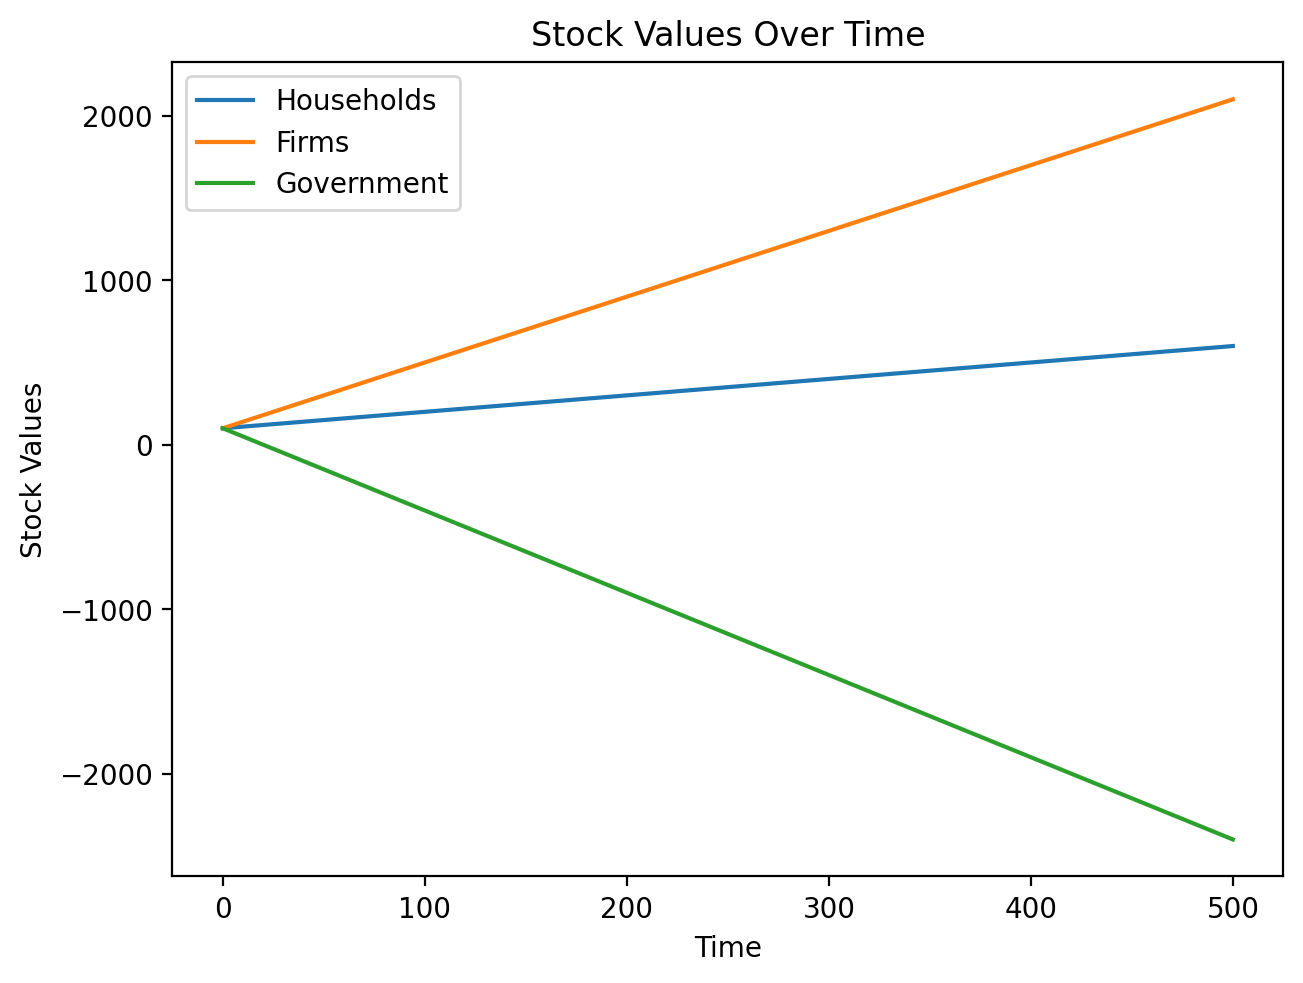

In [10]:
fig, ax = plt.subplots()

stock_df.plot(ax=ax)
ax.set(title="Stock Values Over Time", xlabel="Time", ylabel="Stock Values");

The total money in the economy should be constant. We can check this below:

In [11]:
initial_money = sum(initial_values.values())
total_money_over_time = stock_df.sum(axis=1)
np.allclose(initial_money, total_money_over_time)

True